In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from scipy.signal import spectrogram

## Load the raw signal data

In [2]:
X_signal = np.load('X_signal.npy')
print(X_signal.shape)

(607, 18, 30000)


In [3]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

data_df = pd.read_csv('preprocessed_data.csv')
y = data_df['Outcome']
label_encoder = LabelEncoder()
y_enc = label_encoder.fit_transform(y)

## Create a spectrogram

In [4]:
def create_spectrograms(data):
    spectrograms = []
    for sample in data:
        spec = spectrogram(sample, fs=100)
        spectrograms.append(spec[2])
    return np.array(spectrograms)


X_spectrograms = create_spectrograms(X_signal)
print("Shape of spectrograms:", X_spectrograms.shape)

Shape of spectrograms: (607, 18, 129, 133)


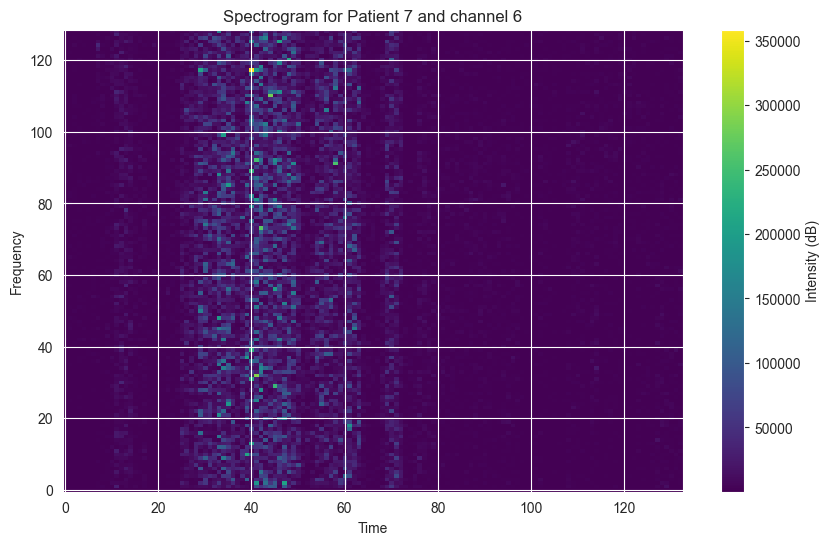

In [55]:
# Plot the spectrogram
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.imshow(X_spectrograms[6, 5, :, :], cmap='viridis', origin='lower', aspect='auto')
plt.colorbar(label='Intensity (dB)')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.title(f'Spectrogram for Patient 7 and channel 6')
plt.show()

In [42]:
# Convert the data into PyTorch tensors
X_tensor = torch.tensor(X_spectrograms, dtype=torch.float32)
y_tensor = torch.tensor(y_enc, dtype=torch.float32)

## Define the transformer model

In [31]:
class EEGTransformerModel(nn.Module):
    def __init__(self, num_frequency_bins, num_channels, num_heads=2, num_layers=1):
        super(EEGTransformerModel, self).__init__()
        encoder_layer = nn.TransformerEncoderLayer(d_model=num_channels * num_frequency_bins, nhead=num_heads)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers)
        self.fc = nn.Linear(num_frequency_bins * num_channels, 1)  # Output layer for binary classification

    def forward(self, x):
        x = x.view(x.size(0), x.size(3), -1)  # (batch_size, num_time_steps, num_frequency_bins * num_channels)
        x = x.permute(1, 0, 2)  # (num_time_steps, batch_size, num_frequency_bins * num_channels)
        x = self.transformer_encoder(x)
        x = x.mean(dim=0)  # (batch_size, num_frequency_bins * num_channels)
        x = self.fc(x).squeeze(1)  # (batch_size,)
        return x

In [32]:
model = EEGTransformerModel(num_frequency_bins=X_spectrograms.shape[2], num_channels=X_spectrograms.shape[1])

## Prepare the data for training

In [43]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
X_tensor = X_tensor.to(device)
y_tensor = y_tensor.to(device)

In [44]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

In [45]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

torch.Size([485, 18, 129, 133]) torch.Size([122, 18, 129, 133]) torch.Size([485]) torch.Size([122])


## Train the transformer model

In [36]:
# Define the loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4)

# Train the model
epochs = 50
batch_size = 8
num_samples = X_train.shape[0]

for epoch in range(epochs):
    model.train()
    total_loss = 0
    indices = torch.randperm(num_samples)

    for i in range(0, num_samples, batch_size):
        batch_indices = indices[i:i + batch_size]
        batch_inputs, batch_labels = X_train[batch_indices], y_train[batch_indices]
        optimizer.zero_grad()
        outputs = model(batch_inputs)
        loss = criterion(outputs, batch_labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    average_loss = total_loss / (num_samples // batch_size + 1)

    print(f"Epoch {epoch + 1}/{epochs}, Loss: {average_loss:.4f}")


Epoch 1/50, Loss: 0.8551
Epoch 2/50, Loss: 0.6465
Epoch 3/50, Loss: 0.3355
Epoch 4/50, Loss: 0.2044
Epoch 5/50, Loss: 0.0841
Epoch 6/50, Loss: 0.0571
Epoch 7/50, Loss: 0.0230
Epoch 8/50, Loss: 0.0353
Epoch 9/50, Loss: 0.0218
Epoch 10/50, Loss: 0.0092
Epoch 11/50, Loss: 0.0015
Epoch 12/50, Loss: 0.0009
Epoch 13/50, Loss: 0.0006
Epoch 14/50, Loss: 0.0005
Epoch 15/50, Loss: 0.0004
Epoch 16/50, Loss: 0.0003
Epoch 17/50, Loss: 0.0003
Epoch 18/50, Loss: 0.0003
Epoch 19/50, Loss: 0.0003
Epoch 20/50, Loss: 0.0002
Epoch 21/50, Loss: 0.0002
Epoch 22/50, Loss: 0.0002
Epoch 23/50, Loss: 0.0002
Epoch 24/50, Loss: 0.0002
Epoch 25/50, Loss: 0.0001
Epoch 26/50, Loss: 0.0001
Epoch 27/50, Loss: 0.0001
Epoch 28/50, Loss: 0.0001
Epoch 29/50, Loss: 0.0001
Epoch 30/50, Loss: 0.0001
Epoch 31/50, Loss: 0.0001
Epoch 32/50, Loss: 0.0001
Epoch 33/50, Loss: 0.0001
Epoch 34/50, Loss: 0.0001
Epoch 35/50, Loss: 0.0001
Epoch 36/50, Loss: 0.0001
Epoch 37/50, Loss: 0.0001
Epoch 38/50, Loss: 0.0001
Epoch 39/50, Loss: 0.

## Test for the performance

In [46]:
model.eval()  # Set the model to evaluation mode
y_pred_probs = torch.sigmoid(model(X_test)).cpu().detach().numpy()
y_pred_labels = np.round(y_pred_probs).astype(int)

# Convert y_test and y_pred_labels back to 1D arrays
y_test_arr = y_test.cpu().detach().numpy().flatten()
y_pred_labels = y_pred_labels.flatten()

# Calculate classification metrics
report = classification_report(y_test_arr, y_pred_labels)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

         0.0       0.34      0.33      0.34        42
         1.0       0.65      0.66      0.66        80

    accuracy                           0.55       122
   macro avg       0.50      0.50      0.50       122
weighted avg       0.55      0.55      0.55       122

